In [9]:
import os
import time
import pandas as pd
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights
import torch.nn as nn
import torch.optim as optim

# Parametry
TRAIN_JSON_PATH = "../data/clean_data_train_01.json"
TEST_JSON_PATH = "../data/clean_data_test_01.json"
IMAGE_DIR = "../data/images/"
MODEL_SAVE_DIR = "../models/"
IMG_HEIGHT, IMG_WIDTH = 140, 100
NUM_IMAGES = 12
BATCH_SIZE = 16
NUM_EPOCHS = 15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset
class CarDataset(Dataset):
    def __init__(self, json_path, image_dir, transform=None, num_images=12, debug=False):
        self.image_dir = image_dir
        self.transform = transform
        self.num_images = num_images
        self.debug = debug

        # Wczytaj dane tabelaryczne
        self.data = pd.read_json(json_path, lines=True)

        # Lista na przefiltrowane próbki
        filtered_samples = []

        for idx, row in self.data.iterrows():
            car_id = str(row["id"])
            
            # Sprawdź, czy jest przynajmniej jeden obrazek dla tej oferty
            has_images = any(
                Path(self.image_dir, f"{car_id}_{i}.jpg").exists() for i in range(num_images)
            )

            if has_images:
                filtered_samples.append(row)

            # Loguj co 1000 wierszy dla debugowania
            if debug and idx % 1000 == 0:
                print(f"Processed {idx}/{len(self.data)} rows. Filtered {len(filtered_samples)} valid samples.")

        # Zaktualizuj dane na przefiltrowane próbki
        self.data = pd.DataFrame(filtered_samples)

        # Usuń `id` i `url` z danych wejściowych modeli
        self.features = self.data.drop(columns=["id", "url", "cena"]).values.astype(float)
        self.prices = torch.tensor(self.data["cena"].values, dtype=torch.float32)

        # ID do wyszukiwania zdjęć
        self.ids = self.data["id"].astype(str).tolist()

        # Wczytaj wszystkie obrazy do pamięci RAM
        self.cached_images = []
        for idx, car_id in enumerate(self.ids):
            images = []
            for i in range(self.num_images):
                image_path = Path(self.image_dir, f"{car_id}_{i}.jpg")
                if image_path.exists():
                    img = Image.open(image_path).convert("RGB")
                    if self.transform:
                        img = self.transform(img)
                    images.append(img)

            # Uzupełnij brakujące obrazy, jeśli jest ich za mało
            while len(images) < self.num_images:
                images.append(images[-1])  # Powielaj brakujące obrazy
            images = torch.stack(images)  # [NUM_IMAGES, C, H, W]
            self.cached_images.append(images)

            # Loguj co 100 załadowanych próbek
            if debug and idx % 100 == 0:
                print(f"Loaded {idx}/{len(self.ids)} samples into memory.")

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        return self.cached_images[idx], torch.tensor(self.features[idx], dtype=torch.float32), self.prices[idx]



# Model
class MultiModalCarPriceRegressor(nn.Module):
    def __init__(self, num_images=12, tabular_input_size=128):
        super(MultiModalCarPriceRegressor, self).__init__()
        
        # Model do ekstrakcji cech z obrazów (ResNet18)
        self.base_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.base_model.fc = nn.Identity()  # Usuń końcową warstwę klasyfikatora

        # Przetwarzanie obrazów
        self.image_embedding_size = 512  # Wyjście ResNet18
        self.image_fc = nn.Linear(self.image_embedding_size, 128)

        # Przetwarzanie danych tabelarycznych
        self.tabular_fc = nn.Sequential(
            nn.Linear(tabular_input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )

        # Warstwa łącząca cechy obrazu i tabelaryczne
        self.combined_fc = nn.Sequential(
            nn.Linear(128 + 64, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Wyjście: przewidywana cena
        )

    def forward(self, images, tabular_features):
        # Przetwarzanie obrazów
        batch_size, num_images, C, H, W = images.size()
        embeddings = []
        for i in range(num_images):
            img_features = self.base_model(images[:, i, :, :, :])
            embeddings.append(img_features)
        embeddings = torch.stack(embeddings, dim=1)
        combined_image_features, _ = embeddings.max(dim=1)
        combined_image_features = self.image_fc(combined_image_features)

        # Przetwarzanie cech tabelarycznych
        tabular_features = self.tabular_fc(tabular_features)

        # Łączenie cech
        combined_features = torch.cat([combined_image_features, tabular_features], dim=1)
        output = self.combined_fc(combined_features)
        return output.squeeze()


# Funkcja kosztu MAPE
class MAPE(nn.Module):
    def __init__(self):
        super(MAPE, self).__init__()

    def forward(self, predictions, targets):
        epsilon = 1e-6  # Aby uniknąć dzielenia przez zero
        mape = torch.mean(torch.abs((targets - predictions) / (targets + epsilon))) * 100
        return mape


# Funkcja do ewaluacji
def evaluate(model, test_loader, criterion, device="cuda", log_interval=100):
    """
    Ewaluacja modelu na zbiorze testowym.
    
    Args:
        model: Model do ewaluacji.
        test_loader: DataLoader zawierający dane testowe.
        criterion: Funkcja kosztu (np. MAPE).
        device: Urządzenie (domyślnie "cuda").
        log_interval: Liczba batchy między logami częściowych wyników.
    
    Returns:
        avg_loss: Średnia wartość straty na zbiorze testowym.
        avg_mape: Średni błąd procentowy (MAPE) na zbiorze testowym.
        y_pred: Lista wszystkich przewidywanych wartości.
        y_true: Lista wszystkich rzeczywistych wartości.
    """
    print("Starting evaluation...")
    
    model.eval()
    total_loss = 0
    total_mape = 0
    total_samples = 0
    y_pred = []
    y_true = []

    with torch.no_grad():
        for batch_idx, (images, tabular_features, prices) in enumerate(test_loader):
            images, tabular_features, prices = images.to(device), tabular_features.to(device), prices.to(device)
            predictions = model(images, tabular_features)

            # Akumulacja strat
            loss = criterion(predictions, prices)
            total_loss += loss.item() * images.size(0)
            total_mape += torch.sum(torch.abs((prices - predictions) / (prices + 1e-6))).item() * 100
            total_samples += images.size(0)

            # Zbieranie przewidywań i wartości rzeczywistych
            y_pred.extend(predictions.cpu().tolist())
            y_true.extend(prices.cpu().tolist())

            # Logowanie częściowych wyników
            if (batch_idx + 1) % log_interval == 0:
                print(f"Batch {batch_idx + 1}/{len(test_loader)}:")
                print(f"  Partial Loss: {loss.item():.4f}, Partial MAPE: {torch.mean(torch.abs((prices - predictions) / (prices + 1e-6))).item() * 100:.2f}%")
    
    # Obliczanie średnich metryk
    avg_loss = total_loss / total_samples
    avg_mape = total_mape / total_samples

    print(f"Evaluation Summary: MAPE: {avg_mape:.2f}%, Average Loss: {avg_loss:.4f}")
    return avg_loss, avg_mape, y_pred, y_true


# Transformacje dla obrazów
transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])




In [ ]:
# Training
train_dataset = CarDataset(TRAIN_JSON_PATH, IMAGE_DIR, transform=transform, num_images=NUM_IMAGES, debug=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)[:100]

# Model, funkcja kosztu, optymalizator
model = MultiModalCarPriceRegressor(num_images=NUM_IMAGES, tabular_input_size=train_dataset.features.shape[1]).to(DEVICE)
criterion = MAPE()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Trenowanie
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    for images, tabular_features, prices in train_loader:
        images, tabular_features, prices = images.to(DEVICE), tabular_features.to(DEVICE), prices.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images, tabular_features)
        loss = criterion(outputs, prices)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss (MAPE): {epoch_loss/len(train_loader):.4f}%")

In [10]:
# Ewaluacja

test_dataset = CarDataset(TEST_JSON_PATH, IMAGE_DIR, transform=transform, num_images=NUM_IMAGES)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model, funkcja kosztu, optymalizator
model = MultiModalCarPriceRegressor(num_images=NUM_IMAGES, tabular_input_size=test_dataset.features.shape[1]).to(DEVICE)
checkpoint = torch.load("../models/car_price_regressor_img_tab.pth", map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])

criterion = MAPE()
optimizer = optim.Adam(model.parameters(), lr=0.001)


avg_loss, avg_mape, y_pred, y_true = evaluate(
    model=model,
    test_loader=test_loader,
    criterion=criterion,
    device=DEVICE,
    log_interval=100
)

C:\Users\tthaddey\AppData\Local\Temp\ipykernel_12844\1241876922.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("../models/car_price_regressor_im

Starting evaluation...
Evaluation Summary: MAPE: 15.05%, Average Loss: 15.0514


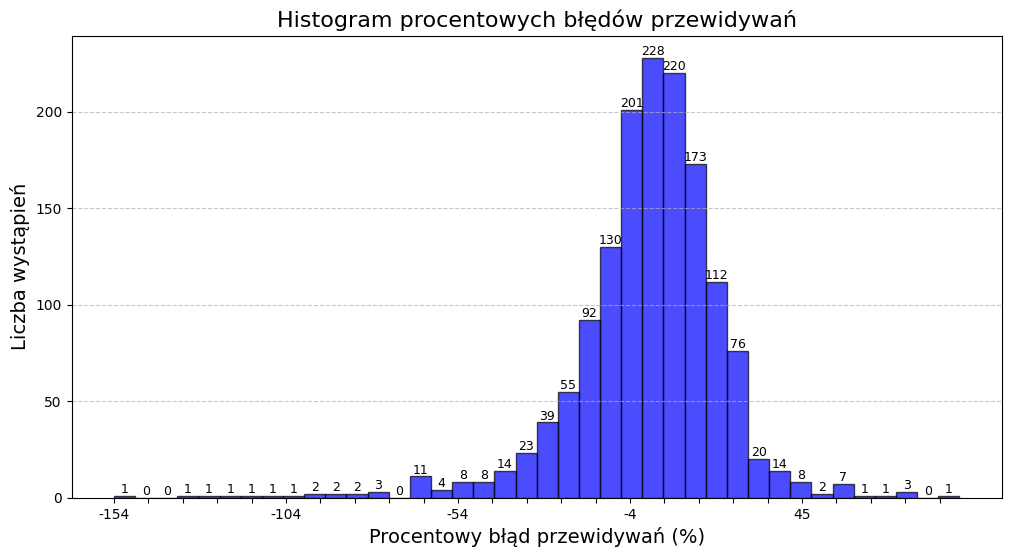

In [12]:
import graphs
import numpy as np
graphs.plot_percentage_error_histogram(np.array(y_pred), np.array(y_true), 40)